## Problem Statement

Aura’s e-commerce customer getmeatshirt.com desires to classify customer product reviews into good or bad with the help of a CNN-LSTM hybrid model.

__Task: Build a CNN-LSTM hybrid model to classify the customer product
reviews into good or bad.__

__Task A:__
1. Load GrammarandProductReviews.csv dataset
2. Create a feature named target by considering that a customer is pleased by
the product if the rating is higher than 3. Any rating below 4 shows that the
customer doesn’t like the product. Use column reviews.rating to create feature
target (Hint: `df['target'] = df['reviews.rating'] < 4` )
3. Create your X with column reviews.text and Y with column target.
4. Split your dataset into train and test in the ratio 80:20
5. Use tokenizer from Keras to vectorize the text samples into a 2D integer tensor
with 20000 words. Fit your tokenizer on train data. `(MAX_NB_WORDS = 20000)`.
Note: you may use different tokenizers (from scikit-learn, NLTK, custom
Python function etc.) This converts the texts into sequences of indices
representing the 20000 most frequent words

6. Convert train texts to sequences using the tokenizer texts_to_sequences
method.
7. Convert test texts to sequences using tokenizer texts_to_sequences method
8. Pad train and test sequence (add 0s at the end until the sequence is of length
150). Consider MAX_SEQUENCE_LENGTH = 150 and this step gives your x_train
and x_test
9. One-hot encode your output classes (True/False).
10. Build a CNN - LSTM hybrid model with the following layers

- Input layer with input `shape = MAX_SEQUENCE_LENGTH` and dtype
int32
- Embedding layer with input `dimension = MAX_NB_WORDS`, output
`dimension =50`, and input `length = MAX_SEQUENCE_LENGTH`
- Conv1D layer with 64 filters and kernel size 5 and activation relu,
followed by MaxPooling1D with pool size = 5
- Hint: MaxPool divides the length of the sequence by
- `Dropout(0.2)`
- Conv1D layer with 64 filters and kernel size 5 and activation relu,
followed by MaxPooling1D with pool size = 5
- `Dropout(0.2)`
- LSTM layer with 64 units
- Dense layer with 2 neurons and activation softmax
11. Compile the model with Adam optimizer and metric accuracy
12. Train the model for 5 epochs and batch size 64
13. Evaluate the model on test text print the test loss and accuracy

__Task B:__
1. As a future and take-home task, train the model with the full dataset available
in the link given in the problem statement.
2. Evaluate the model on full test data and compare the performance
improvement from a subset of the full dataset.


**Dataset Description:**

GrammarandProductReviews.csv [A subset of the dataset with 10000 reviews] to perform this task. This is a list of over 10000 reviews from 1,000 different products provided by [Datafiniti's Product Database](https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews). The dataset includes the text and title of the review, the name and manufacturer of the product, reviewer metadata, and more. We will consider only two columns namely reviews.text and reviews.rating.

In [1]:
# pip install tensorflow==2.17.0 scikeras==0.13.0 keras==3.2.0

In [2]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
import seaborn as sns

#### 1. Load GrammarandProductReviews.csv dataset

In [4]:
import pandas as pd
df = pd.read_excel("./data/GrammarandProductReviews.xlsx")

In [5]:
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.025370e+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.025370e+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,7.341600e+10,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,7.341600e+10
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,7.341600e+10,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,7.341600e+10
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,6.798193e+10,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,6.798193e+10
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,6.798193e+10,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,6.798193e+10


We will only consider the  text of the reviews and the ratings.

We are going to make an approximation in order to predict from the text the satisfaction level of the customer.

In [6]:
df.describe()

,ean,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,upc
count,6.866000e+03,3637.000000,9442.000000,3.637000e+03,4244.000000,10001.000000,1.000100e+04
mean,1.084306e+35,0.136651,0.955624,7.809612e+07,0.474552,4.480752,1.407512e+56
std,6.292871e+35,0.343526,0.205940,3.962908e+07,3.732331,0.852088,3.144459e+57
min,7.991027e+08,0.000000,0.000000,2.187400e+04,0.000000,1.000000,7.991027e+08
25%,4.460002e+10,0.000000,1.000000,6.531562e+07,0.000000,4.000000,4.339641e+10
50%,4.460002e+10,0.000000,1.000000,7.111093e+07,0.000000,5.000000,4.460002e+10
75%,7.560901e+10,0.000000,1.000000,1.028082e+08,0.000000,5.000000,7.965601e+10
max,3.760024e+36,1.000000,1.000000,1.890978e+08,141.000000,5.000000,7.038264e+58


(array([ 249.,    0.,  145.,    0.,    0.,  453.,    0., 2856.,    0.,
        6298.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

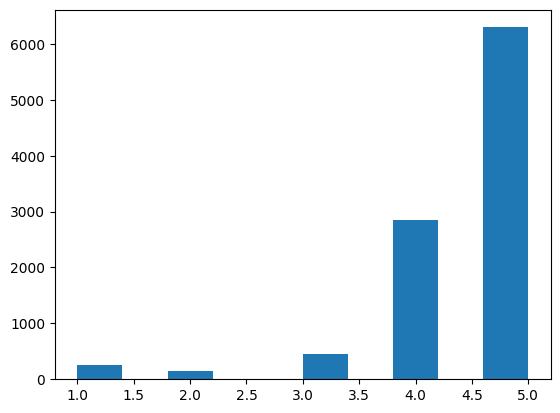

In [7]:
plt.hist(df['reviews.rating'])

#### Observation
- The histogram plot shows the distribution/count of each ratings in the dataset

#### 2. Create a feature named target by considering that a customer is pleased by the product if the rating is higher than 3. Any rating below 4 shows that the customer doesn’t like the product. Use column reviews.rating to create feature targe

In [8]:
df['target'] = df['reviews.rating']<4

Those reviews > 4 will be False and those reviews < 4 will be True

(array([9154.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         847.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

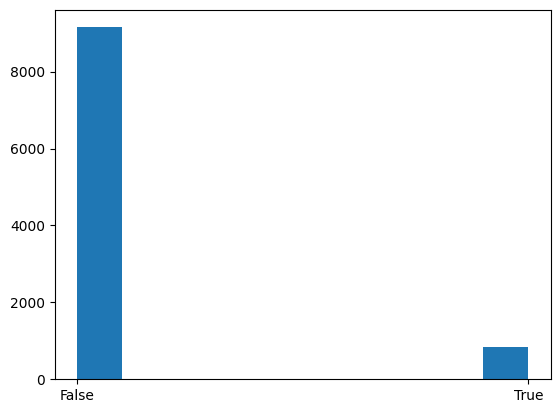

In [9]:
plt.hist(df['target'].astype(str))

#### Observation
- The histogram plot shows the distribution of our good and bad reviews


We can see that we have a lot of "happy" customer due to our target distribution

#### 3. Create your X with column reviews.text and Y with column target.

In [10]:
X = df["reviews.text"]
Y = df["target"]

#### 4. Split your dataset into train and test in the ratio 80:20

In [11]:
train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'],df['target'],test_size = 0.2)

In [12]:
train_text.shape

(8000,)

#### 5. Use tokenizer from Keras to vectorize the text samples into a 2D integer tensor with 20000 words. Fit your tokenizer on train data. (MAX_NB_WORDS = 20000).

Preprocessing text for the (supervised)

Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [13]:
X[1]

'Good flavor. This review was collected as part of a promotion.'

In [14]:
MAX_NB_WORDS = 20_000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
my_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
my_tokenizer.fit_on_texts(texts_train)
my_tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'this': 5,
 'to': 6,
 'it': 7,
 'of': 8,
 'was': 9,
 'as': 10,
 'my': 11,
 'is': 12,
 'for': 13,
 'part': 14,
 'review': 15,
 'collected': 16,
 'promotion': 17,
 'in': 18,
 'great': 19,
 'have': 20,
 'love': 21,
 'use': 22,
 'that': 23,
 'with': 24,
 'product': 25,
 'on': 26,
 'movie': 27,
 'are': 28,
 'but': 29,
 'so': 30,
 'not': 31,
 'wipes': 32,
 'you': 33,
 'all': 34,
 'good': 35,
 'they': 36,
 'clean': 37,
 'like': 38,
 'clorox': 39,
 'one': 40,
 'very': 41,
 'these': 42,
 'up': 43,
 'them': 44,
 'easy': 45,
 'at': 46,
 'when': 47,
 'just': 48,
 'hair': 49,
 'be': 50,
 'really': 51,
 'using': 52,
 'can': 53,
 'me': 54,
 'has': 55,
 'will': 56,
 'out': 57,
 'well': 58,
 "it's": 59,
 'skin': 60,
 'would': 61,
 'cleaning': 62,
 'had': 63,
 'time': 64,
 'if': 65,
 'movies': 66,
 'or': 67,
 'first': 68,
 'get': 69,
 'used': 70,
 'we': 71,
 'only': 72,
 'funny': 73,
 'after': 74,
 'from': 75,
 'also': 76,
 'always': 77,
 'best': 78,
 'house': 79

In [15]:
train_text.shape

(8000,)

#### 6. Convert train texts to sequences using tokenizer texts_to_sequences method.

In [16]:
sequences = my_tokenizer.texts_to_sequences(texts_train)

#### 7. Convert test texts to sequences using tokenizer texts_to_sequences method

In [17]:
sequences_test = my_tokenizer.texts_to_sequences(texts_test)

word_index = my_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9279 unique tokens.


In [18]:
sequences[0]

[115,
 51,
 58,
 26,
 1017,
 43,
 488,
 26,
 224,
 270,
 4,
 826,
 5,
 15,
 9,
 16,
 10,
 14,
 8,
 3,
 17]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [19]:
type(my_tokenizer.word_index), len(my_tokenizer.word_index)

(dict, 9279)

In [20]:
index_to_word = dict((i, w) for w, i in my_tokenizer.word_index.items())

In [21]:
" ".join([index_to_word[i] for i in sequences[0]])

'works really well on picking up spills on both carpet and tile this review was collected as part of a promotion'

In [22]:
texts_train[0]

"i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

The above code shows how to convert tokenized indices back to sentences


Let's have a closer look at the tokenized sequences:

In [23]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
print("min length: %d" % min(seq_lens))

average length: 32.3
max length: 1036
min length: 0


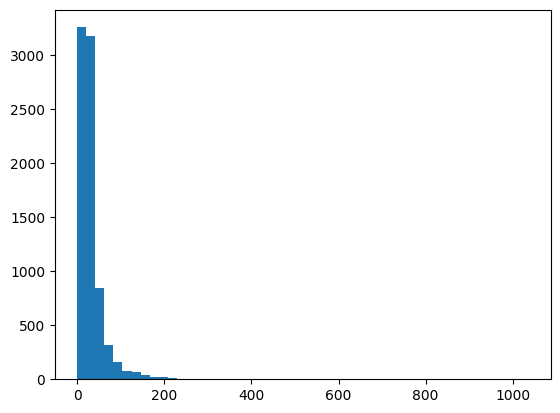

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

In [25]:
train_text.shape

(8000,)

#### Observation
- The histogram plot shows the number of words in reviews


Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 200 symbols:

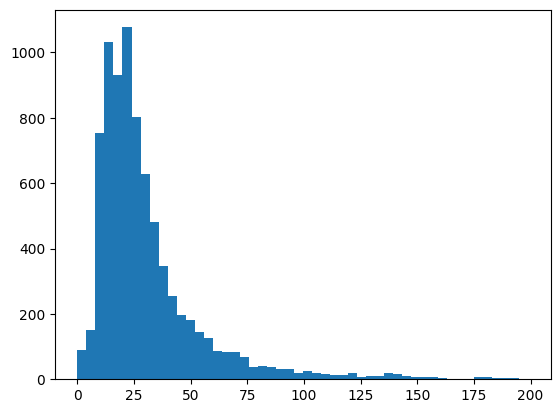

In [26]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

#### Observation
- The histogram plot shows that most of the reviews has words less than 200

#### 8. Pad train and test sequence (add 0s at the end until the sequence is of length 150). Consider MAX_SEQUENCE_LENGTH = 150 and this step gives your x_train and x_test

In [27]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (8000, 150)
Shape of data test tensor: (2001, 150)


In [28]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,  115,   51,   58,
         26, 1017,   43,  488,   26,  224,  270,    4,  826,    5,   15,
          9,   16,   10,   14,    8,    3,   17], d

#### 9. One-hot encode your output classes (True/False).

In [29]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of train label tensor:', y_train.shape)
y_test = to_categorical(np.asarray(y_test))
print('Shape of test label tensor:', y_test.shape)

Shape of train label tensor: (8000, 2)
Shape of test label tensor: (2001, 2)


In [30]:
y_test[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]])

In [31]:
y_train[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]])

In [32]:
import numpy as np

print(f"Train: {np.sum(y_train, axis=0)}")
print(f"Test: {np.sum(y_test, axis=0)}")

Train: [7326.  674.]
Test: [1828.  173.]


#### 10. Build a CNN - LSTM hybrid model with following layers
- Input layer with input shape = MAX_SEQUENCE_LENGTH and dtype int32
- Embedding layer with input dimension = MAX_NB_WORDS, output dimension =50, and input length = MAX_SEQUENCE_LENGTH
- Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5
Hint: MaxPool divides the length of the sequence by 5)
- Dropout(0.2)
- Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5
- Dropout(0.2)
- LSTM layer with 64 units
-Dense layer with 2 neurons and activation softmax


**A simple supervised model in Keras**

Vector space model is well known in information retrieval where each document is represented as a vector. The vector components represent weights or importance of each word in the document. The similarity between two documents is computed using the cosine similarity measure.

![](https://iksinc.files.wordpress.com/2015/04/screen-shot-2015-04-12-at-10-58-21-pm.png?w=768&h=740)

image & explanation taken from : https://iksinc.online/tag/continuous-bag-of-words-cbow/

In [33]:
EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Define layers
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, trainable=True, input_length=MAX_SEQUENCE_LENGTH)(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
# LSTM layer with a hidden size of 64
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)

/Users/xyz-ai/Developer/python3-code/ml/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


We have built an embedding layer mapping each word to a vector representation.

The goal here is to compute the vector representation of all words in each sequence and average them

#### 11. Compile the model with adam optimizer and metric accuracy

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [35]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 50)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 146, 64)        │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,762 (4.08 MB)

 Trainable params: 1,069,762 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(x_train, y_train, validation_split=0.1,
          epochs=50, batch_size=64, verbose=0)

In [37]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

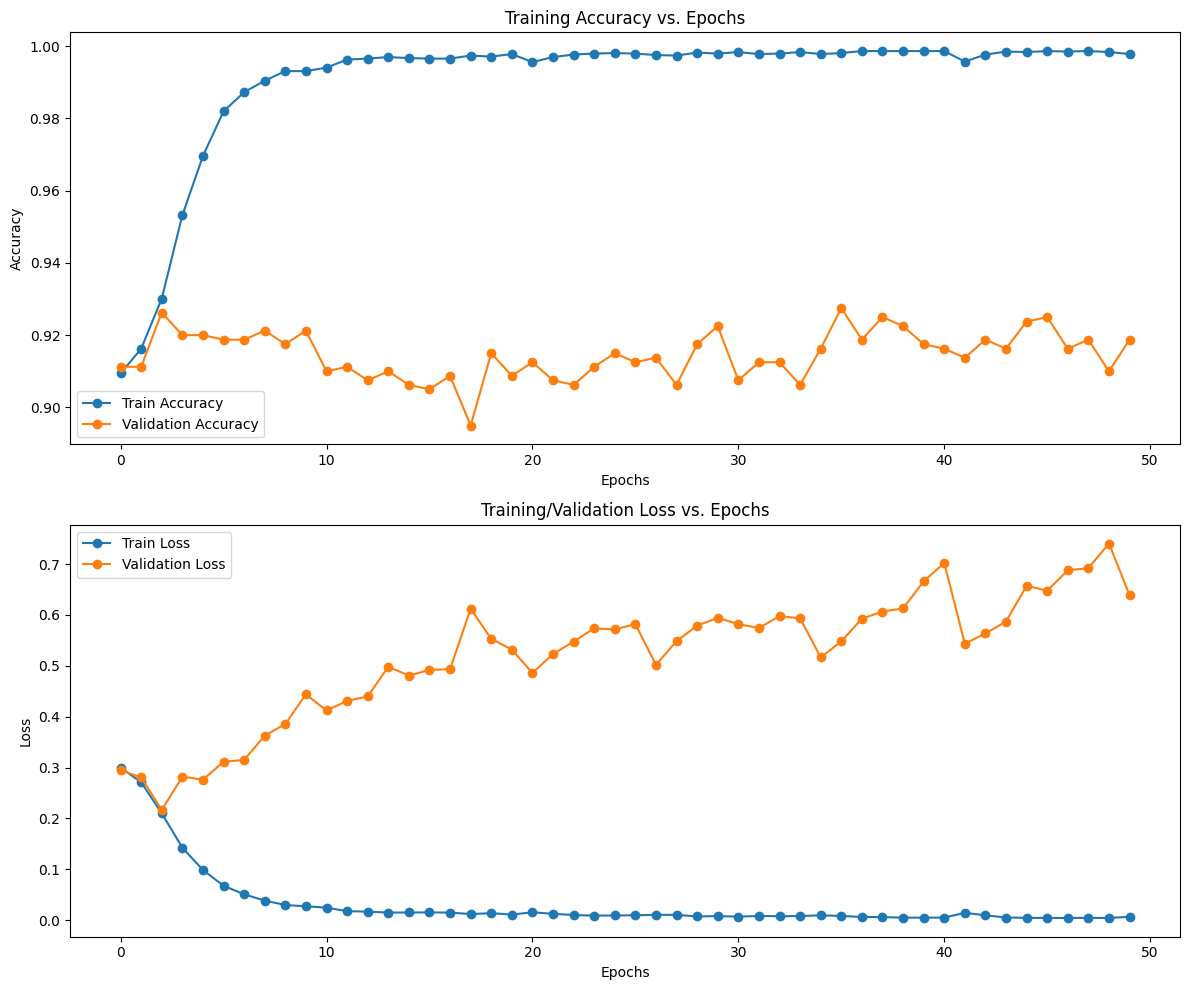

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

#### Observations
- We see a constant decrease in the Training loss where as validation loss starts increasing after a point
- The plot shows that the model starts getting to overfit, and we have a variance problem here
- Adding regularization like drop-out and other techniques may help to stabilize the performance


In [39]:
y_test_1d = np.argmax(y_test, axis=1)

In [40]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test_1d,output_test[:,1]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
test auc: 0.7393926841299755


In [41]:
test_loss, test_accuracy  = model.evaluate(x_test, y_test)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9090 - loss: 0.6899
Test Loss:     0.695366621017456
Test Accuracy: 0.9070464968681335


#### Observation
- The model has given an decent accuracy of 91.75% on unseen test dataset
- The AUC score on test dataset is 28%

## Conclusion

- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- A CNN-LSTM hybrid networks give a solution to use both structural characterization and spatial information together.
- The following projects can replicate similar word embedding models much more efficiently: word2vec and gensim's word2vec (self-supervised learning only), fastText (both supervised and self-supervised learning), Vowpal Wabbit (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.